<a href="https://colab.research.google.com/github/StephenTGibson/MScDataSci_21-22/blob/main/COMP702-MScProject/2D_wave_propagation_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install devito
!pip install devito &> /dev/null

In [ ]:
# import libraries and tools
import numpy as np
rng = np.random.default_rng()
import pandas as pd

from time import perf_counter

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
# from matplotlib.gridspec import GridSpec
import seaborn as sns

from google.colab import drive
drive.mount('/content/gdrive')

import torch
from torch import nn

from devito import Grid, TimeFunction, Operator, Constant, Eq, solve, first_derivative, left

from examples.seismic import Model, plot_velocity
from examples.seismic import TimeAxis
from examples.seismic import RickerSource
from examples.seismic import Receiver

import sys
!git clone https://github.com/StephenTGibson/MScDataSci_21-22.git
sys.path.append('/content/MScDataSci_21-22/COMP702-MScProject')
import utilityFunctions
import physicsInformedNeuralNetworks

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

Mounted at /content/gdrive
Cloning into 'MScDataSci_21-22'...
remote: Enumerating objects: 449, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 449 (delta 152), reused 220 (delta 131), pack-reused 188
Receiving objects: 100% (449/449), 15.05 MiB | 8.17 MiB/s, done.
Resolving deltas: 100% (267/267), done.


device(type='cuda', index=0)

## General definition

In [ ]:
xLimit_m = 1.e3 ### METRES ###
zLimit_m = 1.e3 ### METRES ###
tLimit_s = 0.5 ### SECONDS ###

## Devito

In [ ]:
nx = 200 ### NODES ###
nz = 200 ### NODES ###

absorbingLayer = 10 ### NODES ###

dx = xLimit_m / (nx-1) ### METRES ###
dz = zLimit_m / (nz-1) ### METRES ###

xRange = np.arange(0, nx*dx, dx)
zRange = np.arange(0, nz*dz, dz)
xGrid, zGrid = np.meshgrid(xRange, zRange)

origin = (0., 0.)
spacing = (dx, dz)
shape = (nx, nz)

v = np.empty(shape, dtype=np.float32)
v[:] = 1. ### KM/S ###
# v[:, int(nz*0.5):] = 1.5  ### KM/S ###

devitoModel = Model(vp=v,
                    origin=origin,
                    shape=shape,
                    spacing=spacing,
                    space_order=2,
                    nbl=absorbingLayer,
                    bcs='damp',
                    )

dt = devitoModel.critical_dt
tLimit_ms = tLimit_s * 1e3 ### MILLISECONDS ###
nt = tLimit_ms / dt
timeRange = TimeAxis(start=0, stop=tLimit_ms, step=dt)

u = TimeFunction(name='u',
                 grid=devitoModel.grid,
                 time_order=2,
                 space_order=2,
                 save=int(nt)+2,
                 )

pde = devitoModel.m * u.dt2 - u.laplace + devitoModel.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))

f0 = 0.01 ### kHZ ###
source = RickerSource(name='src',
                      grid=devitoModel.grid,
                      f0=f0,
                      npoint=1,
                      time_range=timeRange,
                      )

source.coordinates.data[0, 0] = int(xLimit_m*0.5) ### METRES ###
source.coordinates.data[0, 1] = int(zLimit_m*0.5) ### METRES ###

sourceTerm = source.inject(field=u.forward, expr=source * dt**2 / devitoModel.m)

op = Operator([stencil] + sourceTerm, subs=devitoModel.spacing_map)

Operator `initdamp` ran in 0.01 s
INFO:Devito:Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
INFO:Devito:Operator `pad_vp` ran in 0.01 s


# Define medium

In [ ]:
# log start time to measure performance
startTime = perf_counter()

# generate solution
summary = op.apply(time=int(nt), dt=dt)

# log end time to measure performance
endTime = perf_counter()
# print total training time
print(f'Training duration: {(endTime-startTime):.2f}s')

FD_solutionWithSrc = np.array(u.data[:,
                              absorbingLayer:u.data.shape[1]-absorbingLayer,
                              absorbingLayer:u.data.shape[2]-absorbingLayer
                              ])
FD_solutionWithSrc.shape

Operator `Kernel` ran in 0.02 s
INFO:Devito:Operator `Kernel` ran in 0.02 s


Training duration: 0.32s


(164, 200, 200)

# PINN

In [ ]:
# hyperParas=pd.read_csv('/content/gdrive/My Drive/wavePINNs/testRecord.csv', index_col=0)
# testNumber = hyperParas.shape[0]+1
# testNumber

45

In [ ]:
# define network characteristics
hiddenLayers = 4
nodesPerLayer = 30
activationFunction = nn.Tanh()
actFuncDf = 'Tanh'

uTrainSlices = 10
sourceEndTime = 2/f0 ### MILLISECONDS ###
fdSliceStart = int(sourceEndTime/dt) + 1
FD_solution = FD_solutionWithSrc[fdSliceStart:]

uTrain = FD_solution[:uTrainSlices]

uTrainDeltas = np.array([
    dt*1e-3,
    dx,
    dz,])
maxArray = np.array([
    FD_solution.shape[0] * dt * 1e-3,
    xLimit_m,
    zLimit_m,
    0.,])

NuTotal = 7200 
NfTotal = 10000
trainingResample = False
NuRange = False
maxIterations = 50000
maxEvaluations = 50000
l1 = 0.001 # residual (PDE)
l2 = 1. # snapshots

model = physicsInformedNeuralNetworks.PINN_2D_AcousticWave( #PINN_2D_AcousticWave
                            hiddenLayers, nodesPerLayer, activationFunction,
                            uTrain, uTrainDeltas, maxArray,
                            NuTotal, NfTotal,
                            trainingResample, NuRange,
                            maxIterations, maxEvaluations,
                            l1, l2,
                            device)

parasDf = sum(p.numel() for p in model.parameters())
print(f'Network parameters: {parasDf}')

model = model.to(device)

Network parameters: 3871


In [ ]:
model.LBFGS_trainer()
optDf = 'LBFGS'

# model.Adam_trainer(40000, 0)
# optDf = 'Adam'

Epoch: 1 --- Elapsed time: 0m0s --- Loss: 0.04772133007645607
Epoch: 2 --- Elapsed time: 0m0s --- Loss: 0.03570344299077988
Epoch: 4 --- Elapsed time: 0m0s --- Loss: 0.032605066895484924
Epoch: 8 --- Elapsed time: 0m0s --- Loss: 0.03248841315507889
Epoch: 16 --- Elapsed time: 0m0s --- Loss: 0.03247533738613129
Epoch: 32 --- Elapsed time: 0m0s --- Loss: 0.0324283093214035
Epoch: 64 --- Elapsed time: 0m1s --- Loss: 0.03241100534796715
Epoch: 128 --- Elapsed time: 0m3s --- Loss: 0.03223883733153343
Epoch: 256 --- Elapsed time: 0m6s --- Loss: 0.028676725924015045
Epoch: 512 --- Elapsed time: 0m12s --- Loss: 0.019038278609514236
Epoch: 1000 --- Elapsed time: 0m24s --- Loss: 0.0011544185690581799
Epoch: 2000 --- Elapsed time: 0m48s --- Loss: 6.0371610743459314e-05
Epoch: 3000 --- Elapsed time: 1m12s --- Loss: 1.9236849766457453e-05


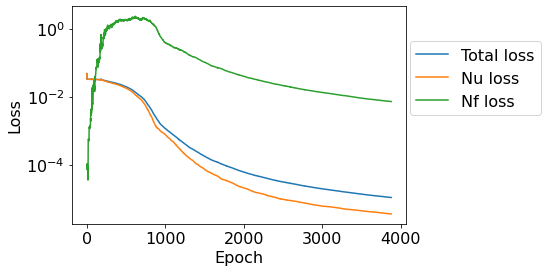

In [ ]:
fig = utilityFunctions.trainingHistoryPlot(model.history,
                                           ['Total loss', 'Nu loss', 'Nf loss'],
                                           'Loss',
                                           '',
                                        #    f'Test ref: {testNumber} - Training loss',
                                           yLogAx=True,
                                           )

# plt.savefig(f'/content/gdrive/My Drive/wavePINNs/TestRef:{testNumber}_loss_curve:_2d_wave_trials', bbox_inches='tight')

In [ ]:
torch.cuda.empty_cache()
PINN_solution = model.generateOutput(FD_solution.shape[0])

difference_solution = FD_solution-PINN_solution

## Plots
Compute u from PINN for all t, x, z in same results form as Devito (np array: t-z-x)

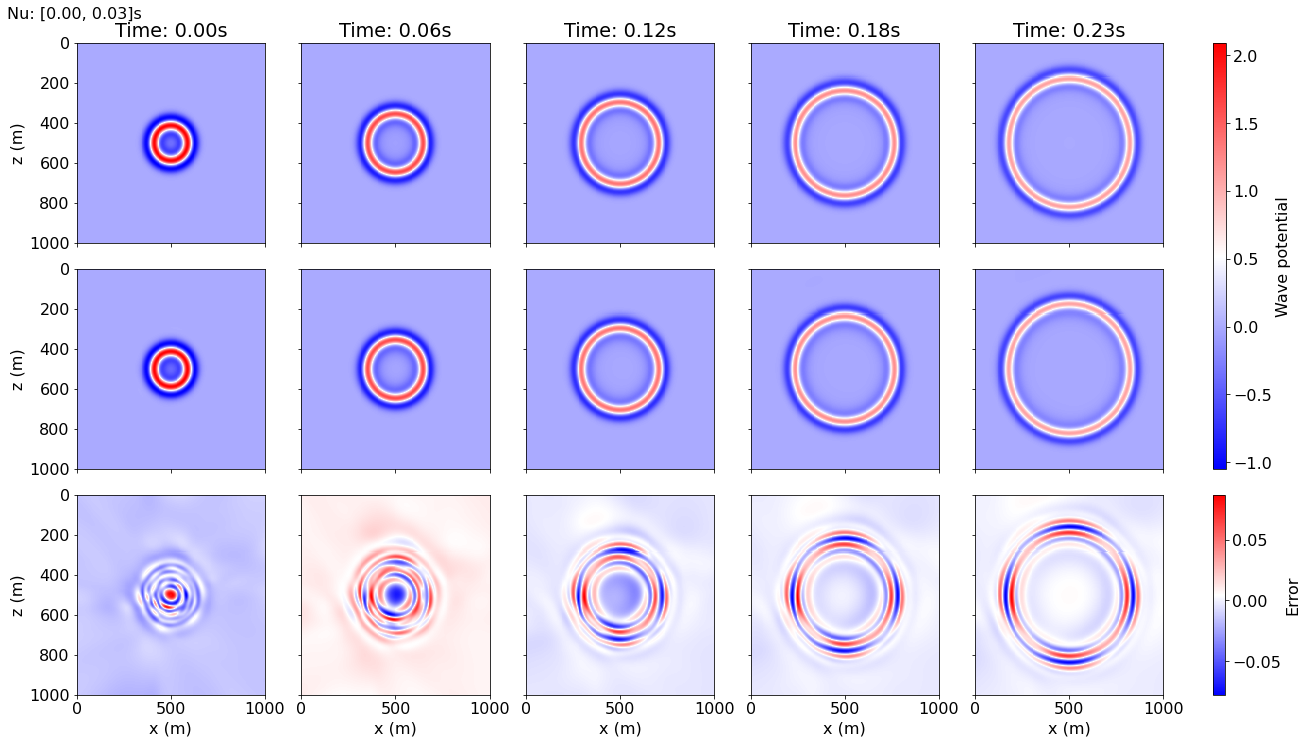

In [ ]:
numPlots = 5

norm = matplotlib.colors.Normalize(min(FD_solution.min(), PINN_solution.min()), max(FD_solution.max(), PINN_solution.max()))
cmap = matplotlib.cm.get_cmap('bwr')
mapping = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
fig, axs = plt.subplots(3, numPlots,
                        figsize=(18, 10),
                        constrained_layout=True,
                        sharex=True,
                        sharey=True,
                        )
axs[0,0].invert_yaxis()

for idx, ax in enumerate(axs[0]):
    plot = ax.pcolormesh(xGrid, zGrid, FD_solution[idx * int(FD_solution.shape[0]/numPlots)].T, norm=norm, cmap='bwr')
    if idx == 0:
        # ax.axhline(y=0.5e3, xmin=0., xmax=1.e3, linewidth=1, color = 'k', linestyle='--')
        # ax.text(40, 400, '1km/s')
        # ax.text(40, 900, '1.5km/s')
        ax.set_ylabel('z (m)')
    ax.set_title(f'Time: {(uTrainDeltas[0] * idx * int(FD_solution.shape[0]/numPlots)):.2f}s')
for idx, ax in enumerate(axs[1]):    
    plot = ax.pcolormesh(xGrid, zGrid, PINN_solution[idx * int(PINN_solution.shape[0]/numPlots)].T, cmap='bwr', norm=norm)
    # ax.set_xlabel('x (m)')
    if idx == 0:
        ax.set_ylabel('z (m)')
clb = fig.colorbar(mapping, ax=axs[:2].ravel(), aspect=60)
clb.set_label('Wave potential')

normErr = matplotlib.colors.Normalize(difference_solution.min(), difference_solution.max())
# cmap = matplotlib.cm.get_cmap('bwr')
mappingErr = matplotlib.cm.ScalarMappable(norm=normErr, cmap=cmap)
for idx, ax in enumerate(axs[2]):    
    plot = ax.pcolormesh(xGrid, zGrid, difference_solution[idx * int(difference_solution.shape[0]/numPlots)].T, cmap='bwr')
    ax.set_xlabel('x (m)')
    if idx == 0:
        ax.set_ylabel('z (m)')
clbErr = fig.colorbar(mappingErr, ax=axs[2].ravel(), aspect=30)
clbErr.set_label('Error')

fig.text(0., 1., f'Nu: [0.00, {(uTrainDeltas[0] * uTrainSlices):.2f}]s')

# fig.suptitle(f'Test ref: {testNumber} - Finite difference (upper) versus PINN (lower) 2D wave propagation', fontsize=20)
# plt.savefig(f'/content/gdrive/My Drive/wavePINNs/Test_ref:{testNumber}_2d_wave_prop', bbox_inches='tight')
plt.show()

In [ ]:
relativeL2error = np.linalg.norm(FD_solution-PINN_solution) / np.linalg.norm(FD_solution)
relativeL2error

0.03509475

# Experiment results

In [ ]:
hyperParas = hyperParas.append({
    'Test ref#': testNumber,
    'Hidden layers': hiddenLayers,
    'Nodes per hidden layer': nodesPerLayer,
    'Learnable parameters': parasDf,
    'Activation function': actFuncDf,
    'Nu': NuTotal,
    'Nf': NfTotal,
    'Nu coefficient': l2,
    'Nf coefficient': l1,
    'Optimiser': optDf,
    'Nu range size' : uTrainSlices,
    'Nu range continuous': NuRange,
    'Resampling': trainingResample,
    'Terminating epoch': model.history.shape[0],
    'Terminating loss': model.history[-1, 0],
    'Training duration': model.trainTime,
    'Relative L2 error': relativeL2error,
    },
    ignore_index=True)

hyperParas.to_csv('/content/gdrive/My Drive/wavePINNs/testRecord.csv')

In [ ]:
hyperParas[(hyperParas['Nodes per hidden layer']==30) & (hyperParas['Activation function']=='Tanh') & (hyperParas['Optimiser']=='LBFGS') & (hyperParas['Nu']==7200)]

,Test ref#,Hidden layers,Nodes per hidden layer,Activation function,Learnable parameters,Nu,Nf,Nu coefficient,Nf coefficient,Optimiser,Nu range size,Nu range continuous,Resampling,Terminating epoch,Terminating loss,Training duration,Relative L2 error
1,2,4,30,Tanh,3871,7200,20000,1.0,0.1000,LBFGS,10,False,False,14152,0.000644,388.426742,0.150702
14,15,4,30,Tanh,3871,7200,10000,1.0,0.1000,LBFGS,10,False,False,17438,0.000511,460.294599,0.130676
15,16,4,30,Tanh,3871,7200,5000,1.0,0.1000,LBFGS,10,False,False,17995,0.000884,471.322394,0.190678
16,17,4,30,Tanh,3871,7200,2500,1.0,0.1000,LBFGS,10,False,False,13184,0.000369,348.637667,0.153315
17,18,4,30,Tanh,3871,7200,2500,1.0,1.0000,LBFGS,10,False,False,15089,0.018340,395.972538,0.764188
18,19,4,30,Tanh,3871,7200,2500,1.0,0.5000,LBFGS,10,False,False,25778,0.001985,657.873187,0.268433
19,20,4,30,Tanh,3871,7200,2500,1.0,0.0100,LBFGS,10,False,False,6111,0.000017,160.461562,0.045614
20,21,4,30,Tanh,3871,7200,2500,1.0,0.0010,LBFGS,10,False,False,10390,0.000036,269.355106,0.634487
21,22,4,30,Tanh,3871,7200,2500,1.0,0.0500,LBFGS,10,False,False,14748,0.000054,377.986884,0.068833
22,23,4,30,Tanh,3871,7200,2500,1.0,0.0100,LBFGS,10,False,False,8832,0.000070,238.051233,0.140170


In [ ]:
hyperParas['Relative L2 error %'] = hyperParas['Relative L2 error'] * 100.

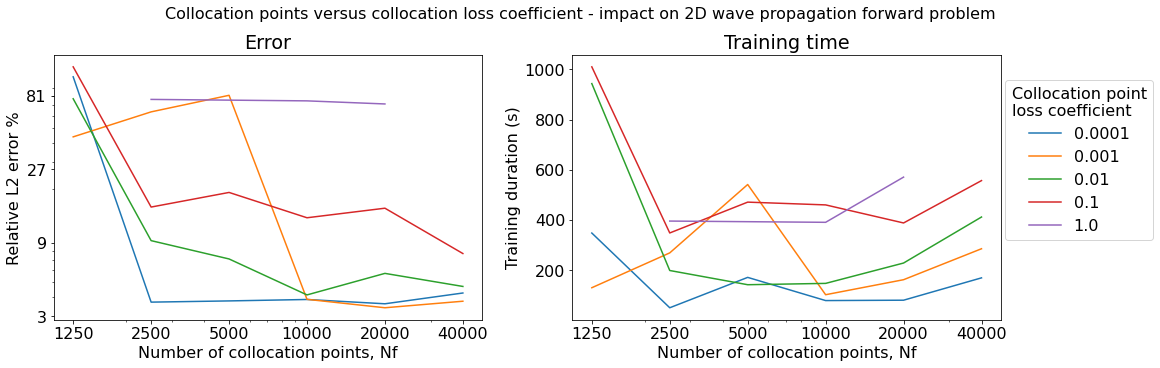

In [ ]:
fig, axs = plt.subplots(1, 2,
                        figsize=(16, 5),
                        constrained_layout=True,
                        )
xAxisLabels = 1250 * 2**(np.arange(1, 7, 1) - 1)

sns.lineplot(
    ax=axs[0],
    data=hyperParas[(hyperParas['Nodes per hidden layer']==30) &\
                    (hyperParas['Activation function']=='Tanh') &\
                    (hyperParas['Optimiser']=='LBFGS') &\
                    (hyperParas['Nu']==7200) &\
                    (hyperParas['Nf coefficient']!=0.5) &\
                    (hyperParas['Nf coefficient']!=0.05)],
    x='Nf',
    y='Relative L2 error %',
    hue='Nf coefficient',
    palette='tab10',
    legend = False,
    ci=None,
    )
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_title('Error')
axs[0].set_xlabel('Number of collocation points, Nf')
axs[0].set_ylabel('Relative L2 error %')
axs[0].set_xticks(xAxisLabels)
axs[0].set_xticklabels(xAxisLabels)
errLabels = 3**np.arange(1, 5, 1)
axs[0].set_yticks(errLabels)
axs[0].set_yticklabels(errLabels)

sns.lineplot(
    ax=axs[1],
    data=hyperParas[(hyperParas['Nodes per hidden layer']==30) &\
                    (hyperParas['Activation function']=='Tanh') &\
                    (hyperParas['Optimiser']=='LBFGS') &\
                    (hyperParas['Nu']==7200) &\
                    (hyperParas['Nf coefficient']!=0.5) &\
                    (hyperParas['Nf coefficient']!=0.05)],
    x='Nf',
    y='Training duration',
    hue='Nf coefficient',
    palette='tab10',
    ci=None,
    )
axs[1].set_xscale('log')
axs[1].set_title('Training time')
axs[1].set_xlabel('Number of collocation points, Nf')
axs[1].set_ylabel('Training duration (s)')
axs[1].set_xticks(xAxisLabels)
axs[1].set_xticklabels(xAxisLabels)

axs[1].legend(title='Collocation point\nloss coefficient', loc=(1.01,0.3))

fig.suptitle("Collocation points versus collocation loss coefficient - impact on 2D wave propagation forward problem", fontsize=16)

fig.savefig(f"/content/gdrive/My Drive/wavePINNs/2D wave: NfvsNfCoeff", bbox_inches='tight')
plt.show()